<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Дубликаты" data-toc-modified-id="Дубликаты-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Дубликаты</a></span></li><li><span><a href="#Пропуски" data-toc-modified-id="Пропуски-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Пропуски</a></span></li><li><span><a href="#Характер-данных-в-1-м-файле" data-toc-modified-id="Характер-данных-в-1-м-файле-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Характер данных в 1-м файле</a></span></li><li><span><a href="#Характер-данных-в-2-м-файле" data-toc-modified-id="Характер-данных-в-2-м-файле-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Характер данных в 2-м файле</a></span></li><li><span><a href="#Характер-данных-в-3-м-файле" data-toc-modified-id="Характер-данных-в-3-м-файле-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Характер данных в 3-м файле</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Разбивка-данных" data-toc-modified-id="Разбивка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разбивка данных</a></span></li><li><span><a href="#Масштабирование" data-toc-modified-id="Масштабирование-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Масштабирование</a></span></li><li><span><a href="#Поиск-моделей" data-toc-modified-id="Поиск-моделей-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Поиск моделей</a></span></li><li><span><a href="#Предсказания-на-валидационной-выборке" data-toc-modified-id="Предсказания-на-валидационной-выборке-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Предсказания на валидационной выборке</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from tqdm.contrib.itertools import product

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
def read_file(name: str):
    # try open local file first then — if failed — open on server
    try:
        return pd.read_csv(f'./datasets/{name}', sep=',')
    except FileNotFoundError:
        try:
            return pd.read_csv(f'/datasets/{name}', sep=',')
        except Exception as e:
            print('Не удалось считать файл с данными на сервере', e, sep='\n')
            return None

    except Exception as e:
        print('Не удалось считать файл с данными на диске', e, sep='\n')
    return None

In [4]:
df1 = read_file('geo_data_0.csv')
df2 = read_file('geo_data_1.csv')
df3 = read_file('geo_data_2.csv')
all_dfs = [df1, df2, df3]

Посмотрим на случайные 7 записей в каждой из трех таблиц

In [5]:
df1.sample(n=7, random_state=1)

,id,f0,f1,f2,product
43660,MUOMg,0.95,0.30,6.82,89.93
87278,OZXkj,0.80,0.23,-2.65,94.20
14317,adoVK,0.73,-0.42,2.65,123.55
81932,8rZOO,0.19,-0.25,-1.00,83.17
95321,RyFFq,0.89,-0.50,4.45,146.29
5405,tBLU2,0.89,0.59,4.12,144.00
33188,9ahU2,-0.90,0.45,6.44,83.79


In [6]:
df2.sample(n=7, random_state=1)

,id,f0,f1,f2,product
43660,lkoIC,2.37,7.47,2.99,80.86
87278,CUVk0,13.48,-10.19,-0.00,0.00
14317,A4aSR,9.99,-15.52,2.01,53.91
81932,rkW6y,8.74,-3.06,4.00,107.81
95321,1CUkY,7.92,1.23,2.00,53.91
5405,ze27Q,12.79,-4.26,5.00,134.77
33188,cAg12,8.57,-5.54,0.00,0.00


In [7]:
df3.sample(n=7, random_state=1)

,id,f0,f1,f2,product
43660,dCoRV,-0.80,0.91,2.89,102.73
87278,TFdxM,-0.40,-0.02,-1.20,72.41
14317,wV83L,0.10,-1.70,1.51,27.08
81932,sgdPb,-0.97,1.91,-3.65,53.21
95321,xSvzy,-0.18,0.81,12.02,112.65
5405,FonLb,1.70,2.46,4.91,171.58
33188,UTsHx,-0.15,-3.81,8.79,160.96


### Дубликаты

`id` намекает, что все записи уникальны, проверим:

In [8]:
df1['id'].value_counts(ascending=False).head()

fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
Name: id, dtype: int64

Хм, видно дубликаты. Посмотрим на один:

In [9]:
df1[df1['id'] == 'fiKDv']

,id,f0,f1,f2,product
16633,fiKDv,0.16,1.03,5.59,95.82
90815,fiKDv,0.05,0.84,6.39,137.35


Посмотрим, сколько их всего в каждом файле:

In [10]:
for i, df in enumerate(all_dfs):
    print(f"Дубликатов в {i + 1}-м файле:"
          f" {df['id'].duplicated(keep=False).sum()} из {len(df)}")

Дубликатов в 1-м файле: 20 из 100000
Дубликатов в 2-м файле: 8 из 100000
Дубликатов в 3-м файле: 8 из 100000


Уберемем записи с этими дублирующимися айдишниками, а потом и весь столбец:

In [11]:
for df in all_dfs:
    df.drop_duplicates(subset=['id'], keep=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.drop(['id'], axis=1, inplace=True)

### Пропуски

In [12]:
for i, df in enumerate(all_dfs):
    missing_df = pd.DataFrame(
        {
            'Количество пропусков': df.isna().sum(),
            '% пропусков': df.isna().mean() * 100
        })

    missing_df = (
        missing_df[missing_df[missing_df.columns[0]] > 0]
        .sort_values(by=missing_df.columns[0])
    )
    print(f'Пропусков в {i + 1}-м файле: {len(missing_df)}')

Пропусков в 1-м файле: 0
Пропусков в 2-м файле: 0
Пропусков в 3-м файле: 0


### Характер данных в 1-м файле

In [13]:
df1.describe(include='all')

,f0,f1,f2,product
count,"99,980.00","99,980.00","99,980.00","99,980.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.71,128.56
max,2.36,1.34,16.00,185.36


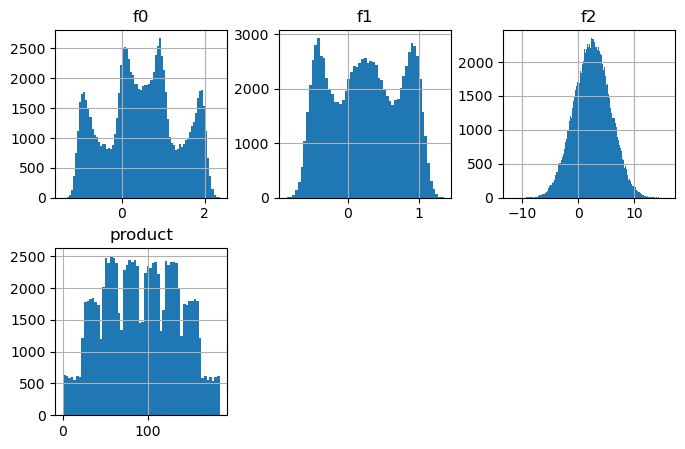

In [14]:
df1.hist(bins='auto', figsize=(8, 5), layout=(2, 3));

Феерично :-)

Посмотрим на корреляции:

In [15]:
corr = df1.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,f0,f1,f2,product
f0,1.00,-0.44,-0.00,0.14
f1,-0.44,1.00,0.00,-0.19
f2,-0.00,0.00,1.00,0.48
product,0.14,-0.19,0.48,1.00


Видим, что есть небольшая между корреляция между f0 и f1.
В целом, ничего критичного (кроме разного масштаба), можно работать.

### Характер данных в 2-м файле

In [16]:
df2.describe(include='all')

,f0,f1,f2,product
count,"99,992.00","99,992.00","99,992.00","99,992.00"
mean,1.14,-4.80,2.49,68.82
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


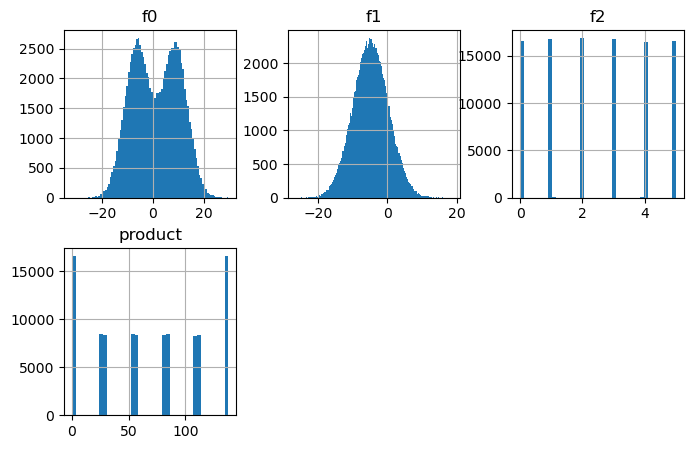

In [17]:
df2.hist(bins='auto', figsize=(8, 5), layout=(2, 3));

Да у нас тут дискретное распределение добычи. Интересно, сколько всего разных

In [18]:
df2['product'].value_counts(sort=False)

3.18      8336
26.95     8468
134.77    8303
137.95    8233
84.04     8430
110.99    8302
53.91     8472
0.00      8235
107.81    8200
57.09     8388
30.13     8306
80.86     8319
Name: product, dtype: int64

Ага, всего 12 штук.

Посмотрим на корреляции:

In [19]:
corr = df2.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,f0,f1,f2,product
f0,1.00,0.18,-0.00,-0.03
f1,0.18,1.00,-0.00,-0.01
f2,-0.00,-0.00,1.00,1.00
product,-0.03,-0.01,1.00,1.00


Корреляция между признаками нет. Отметим дискретные значения 3-го признака
(и очень высокую корреляцию его с таргетом).
В целом, ничего критичного (кроме разного масштаба), можно работать.

### Характер данных в 3-м файле

In [20]:
df3.describe(include='all')

,f0,f1,f2,product
count,"99,992.00","99,992.00","99,992.00","99,992.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.59
max,7.24,7.84,16.74,190.03


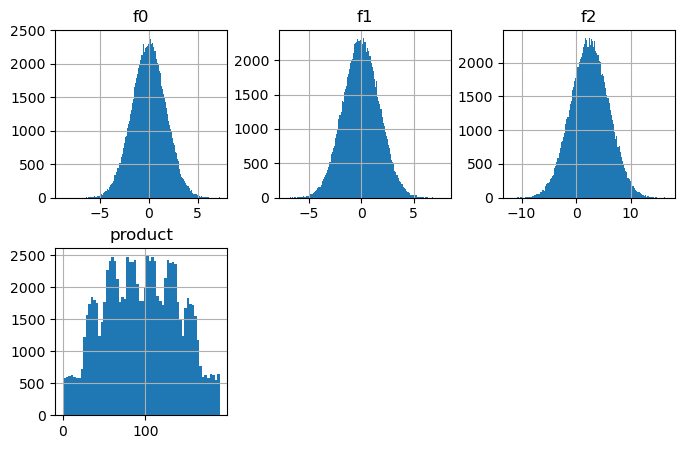

In [21]:
df3.hist(bins='auto', figsize=(8, 5), layout=(2, 3));

О, все три распределения признаков нормальные. А product похож на 1-й файл.

Посмотрим на корреляции:

In [22]:
corr = df3.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,f0,f1,f2,product
f0,1.00,0.00,-0.00,-0.00
f1,0.00,1.00,0.00,-0.00
f2,-0.00,0.00,1.00,0.45
product,-0.00,-0.00,0.45,1.00


Корреляция между признаками нет. В целом, ничего критичного (кроме разного масштаба),
можно работать.

### Вывод

Проблем в данных не найдено за исключением 36 записей на 300к суммарных с одинаковыми
айдишниками (удалили их).

Данные во всех трех файлах имеют абсолютно разный характер распределения.

Таргет (объем запасов в скважине) в 1-м и 3-м файлах на первый взгляд одинаковый.
Во 2-м — имеет дискретное распределение (это странно).

Также запомним, что у нас есть ненормальные распределения.

## Обучение и проверка модели

### Разбивка данных

In [23]:
target_all = []  # здесь и ниже в массивах будет по 3 элемента (по одному на файл)
target_train_all = []
target_test_all = []

features_all = []
features_train_all = []
features_test_all = []

for df in all_dfs:
    features = df.drop('product', axis=1)
    features_all.append(features)

    target = df['product']
    target_all.append(target)

    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=12345)

    features_test_all.append(features_test)
    features_train_all.append(features_train)

    target_train_all.append(target_train)
    target_test_all.append(target_test)

### Масштабирование

Посмотрим еще раз на распределения признаков в трех файлах

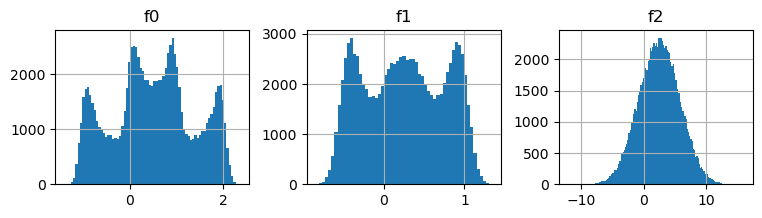

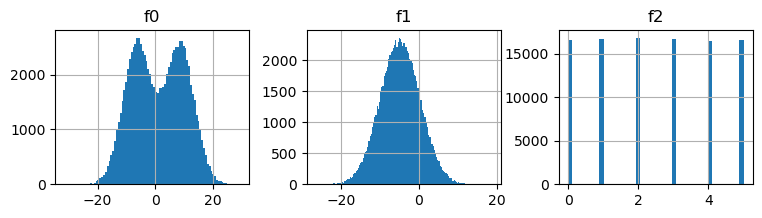

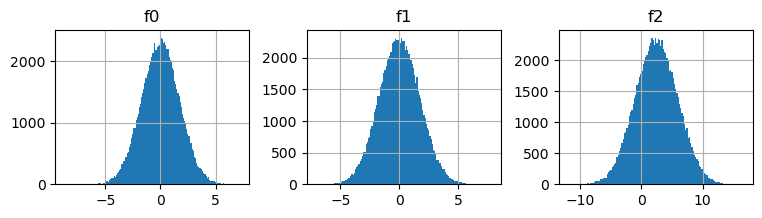

In [24]:
for df in features_all:
    df.hist(bins='auto', layout=(1, 3), figsize=(9, 2));

Посмотрим на выбросы:

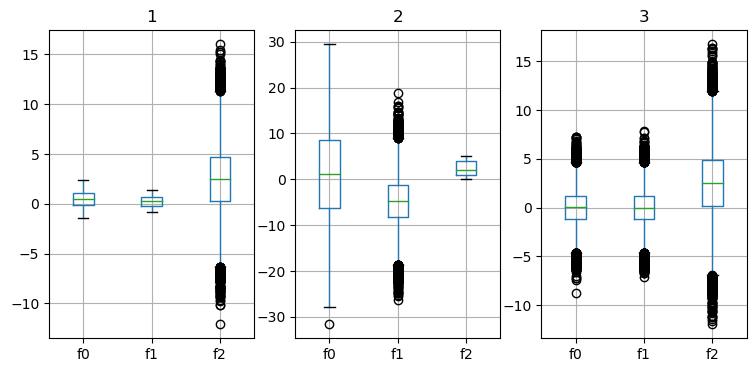

In [25]:
fig = plt.figure(figsize=(9, 4))
for i, df in enumerate(features_all):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.set_title(str(i + 1))
    ax = df.boxplot(ax=ax);
plt.show();

Более-менее нормальные распределения у нас:
- f2 в первом файле;
- f1 во втором;
- f0, f1, f2 в третьем.

На них же и много выбросов, поэтому используем там `RobustScaler` (но только для
train).

In [26]:
robust_columns = [
    ['f2'],
    ['f1'],
    ['f0', 'f1', 'f2']
]

for i in range(3):
    scaler = RobustScaler(with_centering=False, unit_variance=False)
    features_train_all[i][robust_columns[i]] = scaler.fit_transform(
        features_train_all[i][robust_columns[i]])

Выбросы сгладили, теперь промасштабируем:

In [27]:
for i in range(3):
    scaler = StandardScaler()
    scaler.fit(features_train_all[i])
    features_train_all[i] = scaler.transform(features_train_all[i])
    features_test_all[i] = scaler.transform(features_test_all[i])

### Поиск моделей

In [28]:
def get_best_linear_reg(index):
    model = linear_model.LinearRegression()
    model.fit(features_train_all[index], target_train_all[index])
    rmse = mean_squared_error(
        target_test_all[index],
        model.predict(features_test_all[index]),
        squared=False)
    return (model, rmse)

In [29]:
def get_best_ridge(index):
    best_model = None
    best_rmse = float('inf')

    for params in product(
            [1, 0.5, 2, 0.25, 4],
            ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            [0.001, 0.0001]):

        alpha, solver, tol = params
        model = linear_model.Ridge(
            alpha=alpha, solver=solver, tol=tol, random_state=12345)
        model.fit(features_train_all[index], target_train_all[index]);

        rmse = mean_squared_error(
            target_test_all[index],
            model.predict(features_test_all[index]),
            squared=False)

        if rmse < best_rmse:
            best_model = model
            best_rmse = rmse

    # print(f'best rmse={best_rmse:.3f}')
    # print(f'solver={best_model.solver}, alpha={best_model.alpha}, tol={best_model.tol}')
    return (best_model, best_rmse)

In [43]:
def get_best_elastic(index):
    best_model = None
    best_rmse = float('inf')

    for params in product(
            [0, 0.25, 0.5, 0.75, 1],
            ['cyclic', 'random'],
            [100, 200, 500, 800],
            [0.001, 0.0001]):

        l1_ratio, selection, max_iter, tol = params
        model = linear_model.ElasticNet(
            l1_ratio=l1_ratio, selection=selection, max_iter=max_iter,
            tol=tol, random_state=12345)
        model.fit(features_train_all[index], target_train_all[index]);

        rmse = mean_squared_error(
            target_test_all[index],
            model.predict(features_test_all[index]),
            squared=False)

        if rmse < best_rmse:
            best_model = model
            best_rmse = rmse

    print(f'best rmse={best_rmse:.3f}')
    print(f'l1_ratio={best_model.l1_ratio}, selection={best_model.selection},'
          f' max_iter={best_model.max_iter}, tol={best_model.tol}')
    return (best_model, best_rmse)


In [44]:
def get_best_models():
    models_all = []
    rmse_all = []
    for i in range(3):
        (model1, rmse1) = get_best_linear_reg(i)
        (model2, rmse2) = get_best_ridge(i)
        (model3, rmse3) = get_best_elastic(i)

        rmses = [rmse1, rmse2, rmse3]
        models = [model1, model2, model3]

        best_rmse = min(rmses)
        rmse_all.append(best_rmse)

        best_model = models[rmses.index(best_rmse)]
        models_all.append(best_model)

    return models_all, rmse_all

In [45]:
models_all, rmse_all = get_best_models()

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.312e+07, tolerance: 1.470e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.312e+07, tolerance: 1.470e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.312e+07, tolerance: 1.470e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best rmse=53.913
l1_ratio=0, selection=cyclic, max_iter=100, tol=0.001


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.957e+07, tolerance: 1.582e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.957e+07, tolerance: 1.582e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.957e+07, tolerance: 1.582e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best rmse=1.684
l1_ratio=1, selection=cyclic, max_iter=100, tol=0.001


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.776e+07, tolerance: 1.506e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.776e+07, tolerance: 1.506e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

best rmse=55.822
l1_ratio=0, selection=cyclic, max_iter=100, tol=0.001


/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.776e+07, tolerance: 1.506e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


### Предсказания на валидационной выборке

In [33]:
predict_test_all = []
for i in range(3):
    predict_test_all.append(models_all[i].predict(features_test_all[i]))

In [34]:
avg_product_all = []
for i in range(3):
    avg_val = sum(predict_test_all[i]) / len(predict_test_all[i])
    avg_product_all.append(avg_val)
    print(
        f'rmse в {i + 1}-м файле: {rmse_all[i]:.2f}, '
        f'средний запас сырья: {avg_val:.2f}')

rmse в 1-м файле: 53.91, средний запас сырья: 120.62
rmse в 2-м файле: 0.93, средний запас сырья: 69.18
rmse в 3-м файле: 55.82, средний запас сырья: 121.91


Посмотрим на гистограмму ошибок предсказаний для всех трех файлов

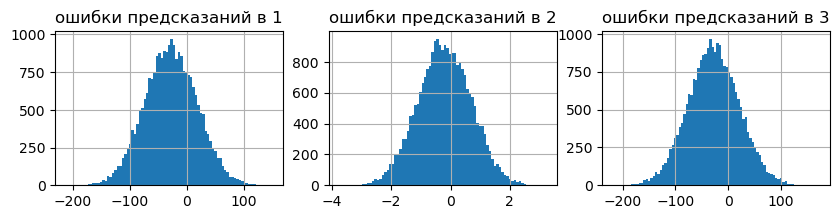

In [35]:
fig = plt.figure(figsize=(10, 2))
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.set_title('ошибки предсказаний в ' + str(i + 1))
    (target_test_all[i] - predict_test_all[i]).hist(
        bins='auto', ax=ax);
plt.show();

Вспомним распределения реальных значений

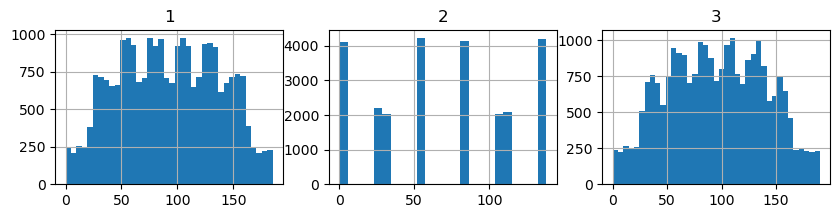

In [36]:
fig = plt.figure(figsize=(10, 2))
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.set_title(str(i + 1))
    target_test_all[i].hist(
        bins='auto', ax=ax);
plt.show();

In [37]:
target_pd = pd.DataFrame(
    {
        '1': target_test_all[0],
        '2': target_test_all[1],
        '3': target_test_all[2]
    })

target_pd.describe()

,1,2,3
count,"24,995.00","24,998.00","24,998.00"
mean,92.39,68.98,94.55
std,44.35,45.97,44.57
min,0.00,0.00,0.01
25%,56.26,26.95,59.07
50%,91.60,57.09,94.20
75%,128.59,110.99,130.34
max,185.35,137.95,190.03


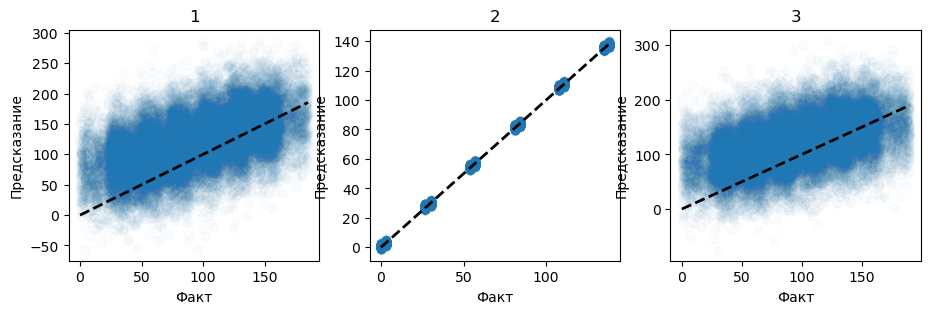

In [38]:
fig = plt.figure(figsize=(11, 3))
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.set_title(str(i + 1))
    ax.scatter(
        target_test_all[i], predict_test_all[i],
        alpha=0.02)

    ax.plot(
        [target_test_all[i].min(), target_test_all[i].max()],
        [target_test_all[i].min(), target_test_all[i].max()],
        'k--', lw=2)

    ax.set_xlabel('Факт')
    ax.set_ylabel('Предсказание')
plt.show()

### Вывод

Всё очень плохо для нормальных распределений добычи (1-й и 3-й файлы)
средняя ошибка в районе 54. Если учесть, что общее распределение
там 0...180, ошибка, мягко говоря, немаленькая.
Среднее предсказанное значение добычи: 120 vs ≈ 93 реальные.

На дискретном наборе таргета (напомним, что во 2-м файле всего 12 разных значений),
у нас все гораздо лучше: средняя ошибка 0,93

## Подготовка к расчёту прибыли

In [39]:
BUDGET = 1e10
INCOME_PER_KILOBARREL = 450e3

REVIEW_COUNT = 500
SELECTED_COUNT = 200

MAX_FAILURE_CHANCE = 0.025

In [40]:
minimal_product = BUDGET / INCOME_PER_KILOBARREL / SELECTED_COUNT
print(f'Минимальный объем сырья на одной скважине (тыс. бар):'
      f' {minimal_product:.2f}')

print('---')
for i in range(3):
    print(f'предсказанный средний запас сырья в {i + 1}: '
          f'{avg_product_all[i]:.2f}')

Минимальный объем сырья на одной скважине (тыс. бар): 111.11
---
предсказанный средний запас сырья в 1: 120.62
предсказанный средний запас сырья в 2: 69.18
предсказанный средний запас сырья в 3: 121.91


Вывод: прибыль будет, если каждая из 200 итоговых скважин даст больше 111.11
тыс. т баррелей. Посмотрим, как справятся наши модели (с их-то погрешностями)

## Расчёт прибыли и рисков 

In [41]:
def revenue(target, predicted, count):
    predicted_sorted = predicted.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:count]
    total_volume = selected.sum()
    return total_volume * INCOME_PER_KILOBARREL - BUDGET

In [42]:
for region_index in range(3):
    state = np.random.RandomState(12345)

    predicted = pd.Series(predict_test_all[region_index], name='product')
    target = target_test_all[region_index].reset_index(drop=True)

    values = []
    for i in range(1000):
        target_sample = target.sample(REVIEW_COUNT, replace=True, random_state=state)
        predicted_sample = predicted.loc[target_sample.index]
        values.append(revenue(target_sample, predicted_sample, SELECTED_COUNT))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(1 - 0.025)

    mean = values.mean()
    loss_probability = (values < 0).mean()
    is_ok = "плохо" if loss_probability >= MAX_FAILURE_CHANCE else "ok"
    print(f'Средняя прибыль в регионе {region_index + 1}: {mean:,.0f}')
    print(f'95% дов. интервал {lower:,.0f} ... {upper:,.0f}')
    print(f'вероятность убытков: {loss_probability:.1%}, {is_ok}')
    print()

Средняя прибыль в регионе 1: 389,897,463
95% дов. интервал -174,911,190 ... 928,851,152
вероятность убытков: 8.2%, плохо

Средняя прибыль в регионе 2: 535,199,743
95% дов. интервал 86,681,038 ... 958,082,040
вероятность убытков: 1.4%, ok

Средняя прибыль в регионе 3: 350,571,605
95% дов. интервал -173,998,524 ... 877,299,634
вероятность убытков: 11.3%, плохо



## Вывод



Регион №2 — единственный регион с «гарантированной» прибылью по нашим моделям.

В остальных случаях погрешности слишком большие. Что логично: зависмости в 1 и 2
нелинейные, а полиномы мы здесь не используем. Второй регион же отработал хорошо,
потому что распределение целевого признака дискретное всего из 12 значений
и имеет небывалую корреляцию в единицу с 3-м признаком.

==

Просьба к ревьюеру: если ошибок нет = переделок не требуется, «пометьте»,
пожалуйста, работу принятой. Чтобы мог максимально быстро начать работу над
сборным проектом (его условия не видно, пока все «обычные» проекты не приняты)

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован